### Our Approach
We aim to construct features from raw data, including bond rates and $\beta_{0-2}$ values, to predict future bond rates across different maturities. Our constructed features includes:
1. $P$ - representing raw bond rates and $\beta_{0-2}$ values.
2. $ret$ - the log-return.
3. $ret_{MA}$ - the log-return with moving average over windows of 5, 30, and 120 days.

Utilizing the auto-ML library, specifically pycaret, we engage machine learning algorithms to aggregate these features for predicting future rates. Our prediction target is:
$$ret_{\text{FUTURE-1day}}$$

Predicting the log-return in rates, which is dimensionless and unaffected by spikes in rates outside the training set's range, is our focus. We also attempt predicting the log-return of $\beta$ s, aiming to forecast future curve fits and potentially unveil profitable trading strategies.

### Result
The summary of our findings is as follows:

Utilizing the naively constructed features (and their subsets) with a variety of models (including tree-based models, neural networks, and linear regression), we could not surpass a random regression outcome for one-day-ahead return prediction. A similar outcome is observed for $\beta$ prediction, with nearly $0$ $R^2$ on the training set, indicating minimal improvement over naive mean prediction. The test set exhibited a negative $R^2$, suggesting predictions worse than naive mean predictions:
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Adjusting the prediction target, including binary classification and raw rate value prediction, was also explored.

Furthermore, improper cross-validation splitting, e.g., using k-fold cross-validation, falsely inflates $R^2$. This phenomenon, stemming from look-ahead bias (data leakage), results in poor test set performance. A time-series split should be employed to lower $R^2$ yet yield more reliable and realistic outcomes for trading scenarios.

### Potential Improvement
Future enhancements may include:
- Developing additional features, including:
    - Macroeconomic indicators.
    - Other financial instruments.
    - Further time series features.
- Incorporating more sophisticated models, such as:
    - Long Short-Term Memory (LSTM) networks.
    - Deep Neural Networks (DNNs).
- Refining the prediction target, for instance, by forecasting returns over longer time horizons.

### Result of falsely using K-Fold Cross-Validation
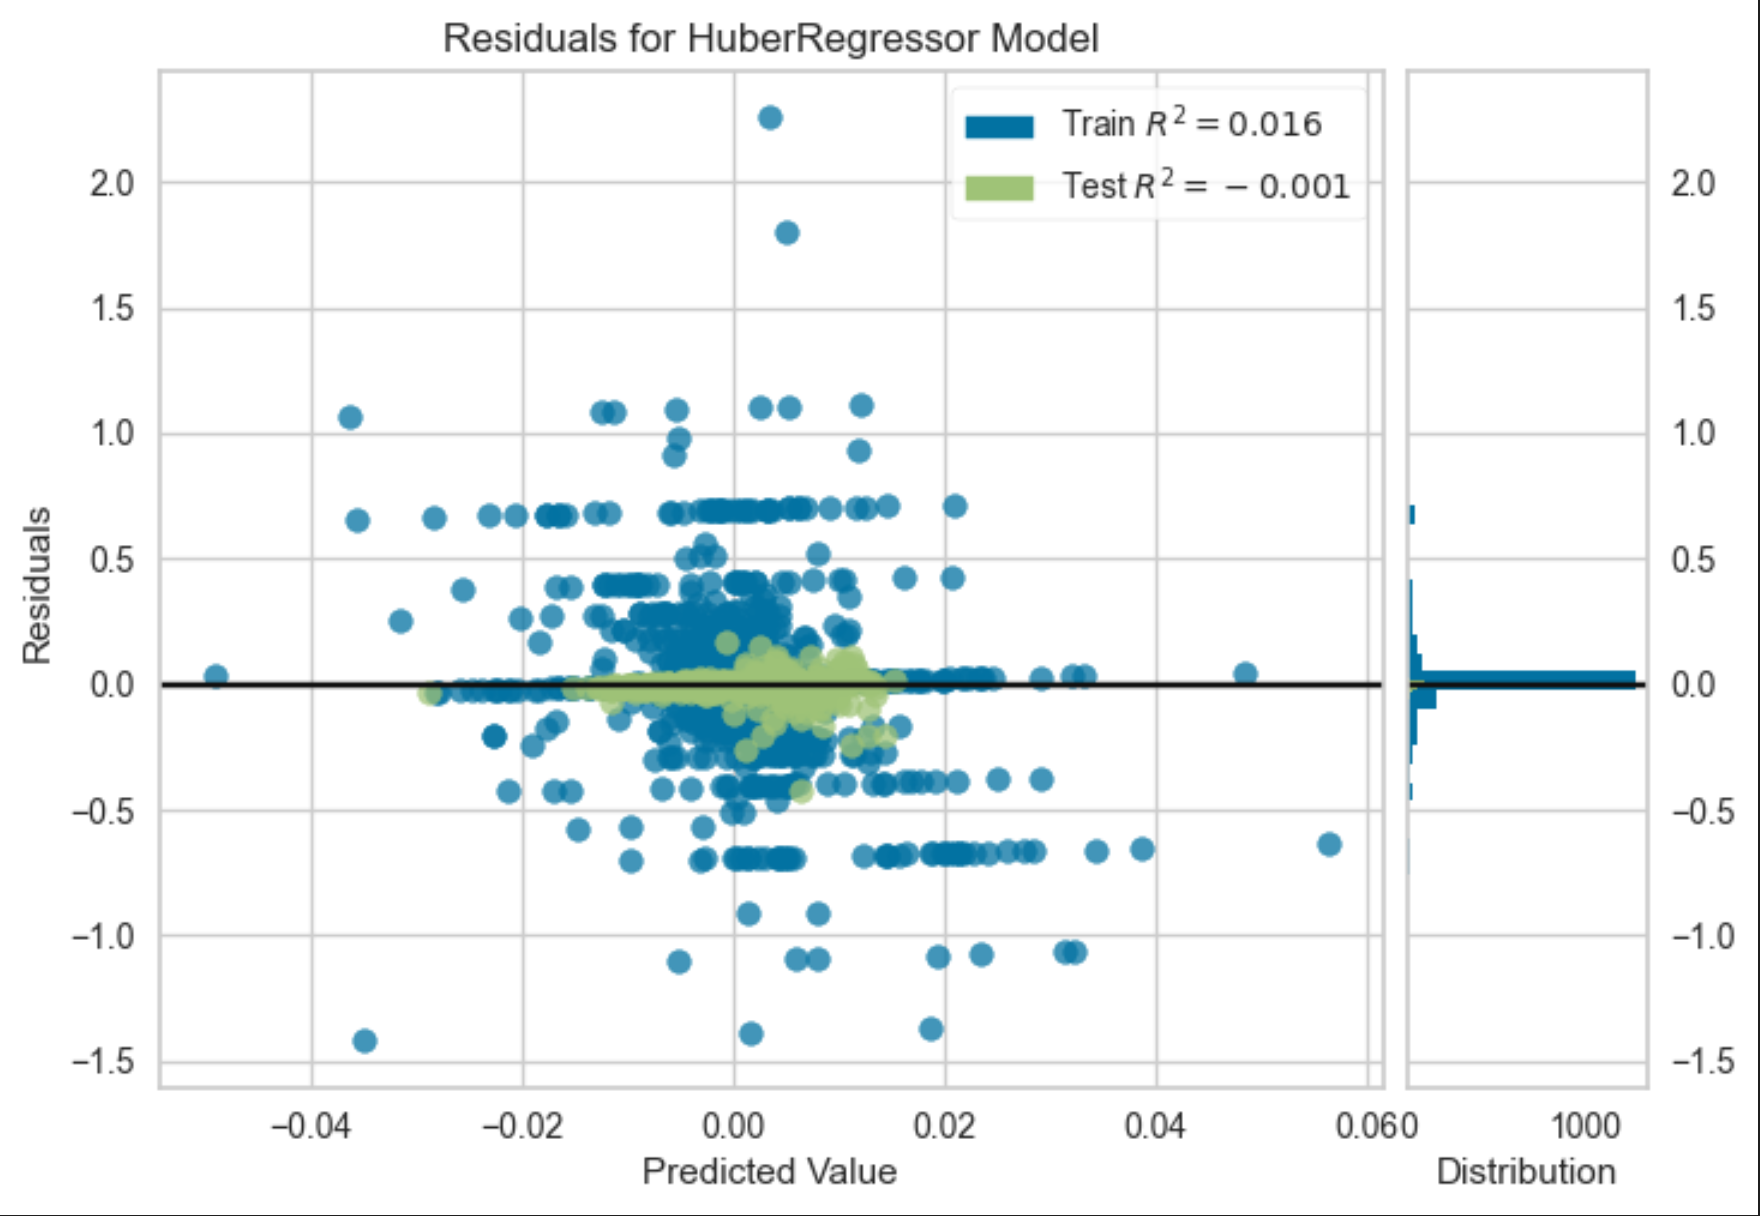

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import seaborn as sns
from scipy.stats import mode
from functools import reduce
from pykalman import KalmanFilter
import pmdarima as pm

In [20]:
# df = pd.read_csv("training_data_037.csv")
# test_df = pd.read_csv("backtest_037.csv")

test_df = pd.read_csv('backtest_047_svenson.csv')
df = pd.read_csv('training_data_047_svenson.csv')

names = ['DGS3MO', 'DGS6MO', 'DGS1', 'DGS2' ,'DGS3', 'DGS5', 'DGS7','DGS10']
test_df = test_df.drop(columns="observation_date")
# construct log returns of each column
for name in names:
    test_df[name+'_ret'] = np.log(test_df[name]) - np.log(test_df[name].shift(1))
for name in ['beta_0', 'beta_1', 'beta_2']:
    test_df[name+'_ret'] = test_df[name] - test_df[name].shift(1)
# drop the row with nan
test_df["target"] = test_df["DGS3MO_ret"].shift(-1)
test_df = test_df.dropna()

,Description,Value
0,Session id,1469
1,Target,target
2,Target type,Regression
3,Original data shape,"(2518, 26)"
4,Transformed data shape,"(2518, 26)"
5,Transformed train set shape,"(1987, 26)"
6,Transformed test set shape,"(531, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.0562,0.0241,0.1247,-0.0008,0.0938,1.0097,0.0200
en,Elastic Net,0.0562,0.0241,0.1247,-0.0008,0.0938,1.0097,0.0050
dummy,Dummy Regressor,0.0562,0.0241,0.1247,-0.0008,0.0938,1.0097,0.0150
llar,Lasso Least Angle Regression,0.0562,0.0241,0.1247,-0.0008,0.0938,1.0097,0.0150
omp,Orthogonal Matching Pursuit,0.0592,0.0231,0.1235,-0.0630,0.0827,1.1162,0.0050
svm,Support Vector Regression,0.0609,0.0239,0.1256,-0.1018,0.0910,1.5216,0.0150
ard,Automatic Relevance Determination,0.0636,0.0233,0.1262,-0.2665,0.0825,1.4999,0.0150
knn,K Neighbors Regressor,0.0830,0.0289,0.1476,-1.5191,0.0993,2.9235,0.0200
ada,AdaBoost Regressor,0.0903,0.0310,0.1533,-1.7654,0.0994,3.0131,0.0650
lightgbm,Light Gradient Boosting Machine,0.0962,0.0301,0.1557,-2.5832,0.0995,3.8432,0.2300


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0163,0.0010,0.0321,-0.0001,0.0288,0.9912
1,0.0960,0.0472,0.2174,-0.0014,0.1589,1.0282
Mean,0.0562,0.0241,0.1247,-0.0008,0.0938,1.0097
Std,0.0398,0.0231,0.0926,0.0007,0.0650,0.0185


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0163,0.0010,0.0321,-0.0001,0.0288,0.9912
1,0.0960,0.0472,0.2174,-0.0014,0.1589,1.0282
Mean,0.0562,0.0241,0.1247,-0.0008,0.0938,1.0097
Std,0.0398,0.0231,0.0926,0.0007,0.0650,0.0185


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


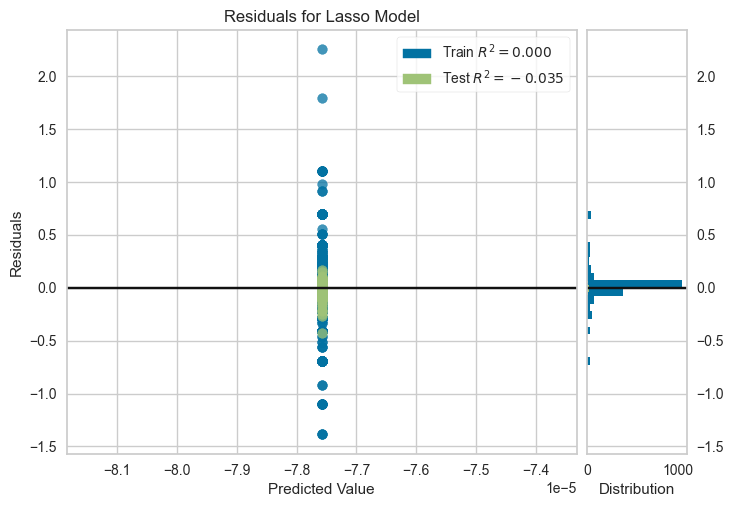

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.0195,0.0019,0.0436,-0.0351,0.0400,0.9996


In [21]:
from pycaret.regression import *

train_df = df.drop(columns="observation_date")
# construct log returns of each column
for name in names:
    train_df[name+'_ret'] = np.log(train_df[name]) - np.log(train_df[name].shift(1))
for name in ['beta_0', 'beta_1', 'beta_2']:
    train_df[name+'_ret'] = train_df[name] - train_df[name].shift(1)
# drop the row with nan
train_df["target"] = train_df["DGS3MO_ret"].shift(-1)
train_df = train_df.dropna()
train_df_raw = train_df.drop(columns=["beta_0", "beta_1", "beta_2", "beta_0_ret","beta_1_ret","beta_2_ret"])
train_df_ret = train_df.drop(columns=["DGS3MO", "DGS6MO", "DGS1", "DGS2" ,"DGS3", "DGS5", "DGS7","DGS10"])
# for name in [_+"_ret" for _ in ["DGS3MO", "DGS6MO", "DGS1", "DGS2" ,"DGS3", "DGS5", "DGS7","DGS10"]+["beta_0", "beta_1", "beta_2"]]:
#     for window in [5,30]:
#         train_df_ret[name+"_rolling_mean_"+str(window)] = train_df_ret[name].rolling(window).mean()
train_df_ret.dropna(inplace=True)

rg1 = setup(train_df, target = 'target',test_data = test_df,index = False, fold_strategy="timeseries", fold = 2, fold_shuffle=False, data_split_shuffle = False) 
# rg1 = setup(train_df_ret, target = 'target',test_data = test_df,index = False) 

# Compare all models    
best_model = compare_models(turbo = False)

# create_model
model = create_model(best_model)
# model = create_model('rf')

# tune_model
tuned_model = tune_model(model)

plot_model(model)

predictions = predict_model(model)

In [22]:
df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("backtest.csv")
names = ['DGS3MO', 'DGS6MO', 'DGS1', 'DGS2' ,'DGS3', 'DGS5', 'DGS7','DGS10']
test_df = test_df.drop(columns="observation_date")
# construct log returns of each column
for name in names:
    test_df[name+'_ret'] = np.log(test_df[name]) - np.log(test_df[name].shift(1))
for name in ['beta_0', 'beta_1', 'beta_2']:
    test_df[name+'_ret'] = test_df[name] - test_df[name].shift(1)
# drop the row with nan
test_df["target"] = test_df["DGS3MO_ret"].shift(-1)>0
test_df = test_df.dropna()

,Description,Value
0,Session id,5746
1,Target,target
2,Target type,Binary
3,Original data shape,"(2520, 24)"
4,Transformed data shape,"(2520, 24)"
5,Transformed train set shape,"(1988, 24)"
6,Transformed test set shape,"(532, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rbfsvm,SVM - Radial Kernel,0.6511,0.5127,0.0000,0.0000,0.0000,0.0000,0.0000,0.1200
dummy,Dummy Classifier,0.6511,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150
mlp,MLP Classifier,0.6465,0.5541,0.0415,0.3438,0.0708,0.0262,0.0295,0.1400
knn,K Neighbors Classifier,0.6405,0.5289,0.0837,0.4106,0.1386,0.0210,0.0324,0.0200
ridge,Ridge Classifier,0.6405,0.0000,0.1335,0.6070,0.1873,0.0276,0.0703,0.0150
et,Extra Trees Classifier,0.6382,0.5317,0.0564,0.3640,0.0895,0.0206,0.0221,0.0550
rf,Random Forest Classifier,0.6095,0.5145,0.1224,0.3205,0.1473,0.0178,0.0082,0.0650
gpc,Gaussian Process Classifier,0.6042,0.5141,0.1154,0.3085,0.1296,0.0094,0.0038,4.6950
lightgbm,Light Gradient Boosting Machine,0.5952,0.5415,0.1790,0.3523,0.1966,0.0264,0.0219,0.2100
lr,Logistic Regression,0.5952,0.5455,0.3944,0.4931,0.3160,0.0141,0.0382,0.0250


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5680,0.5091,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7341,0.5163,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.6511,0.5127,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0831,0.0036,0.0000,0.0000,0.0000,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5680,0.4796,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7341,0.5201,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.6511,0.4998,0.0000,0.0000,0.0000,0.0000,0.0000
Std,0.0831,0.0202,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


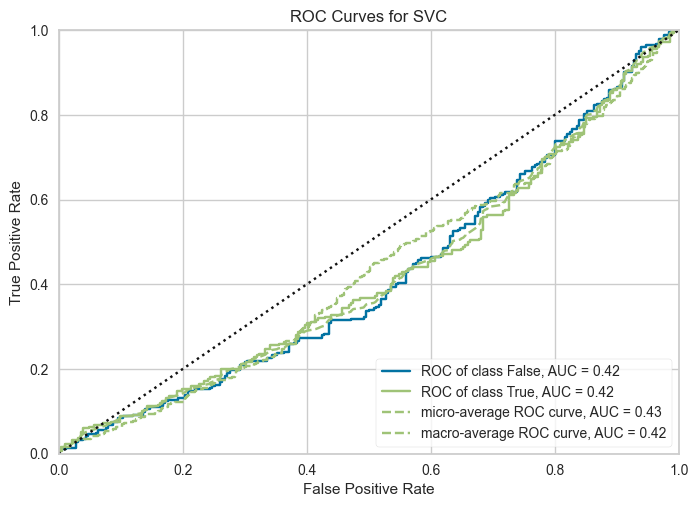

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Radial Kernel,0.5301,0.4190,0.0000,0.0000,0.0000,0.0000,0.0000


In [24]:
from pycaret.classification import *

train_df = df.drop(columns="observation_date")
# construct log returns of each column
for name in names:
    train_df[name+'_ret'] = np.log(train_df[name]) - np.log(train_df[name].shift(1))
for name in ['beta_0', 'beta_1', 'beta_2']:
    train_df[name+'_ret'] = train_df[name] - train_df[name].shift(1)
# drop the row with nan
train_df["target"] = train_df["DGS3MO_ret"].shift(-1)>0
train_df = train_df.dropna()
train_df_raw = train_df.drop(columns=["beta_0", "beta_1", "beta_2", "beta_0_ret","beta_1_ret","beta_2_ret"])
train_df_ret = train_df.drop(columns=["DGS3MO", "DGS6MO", "DGS1", "DGS2" ,"DGS3", "DGS5", "DGS7","DGS10"])
# for name in [_+"_ret" for _ in ["DGS3MO", "DGS6MO", "DGS1", "DGS2" ,"DGS3", "DGS5", "DGS7","DGS10"]+["beta_0", "beta_1", "beta_2"]]:
#     for window in [5,30]:
#         train_df_ret[name+"_rolling_mean_"+str(window)] = train_df_ret[name].rolling(window).mean()
train_df_ret.dropna(inplace=True)

rg1 = setup(train_df, target = 'target',test_data = test_df,index = False, fold_strategy="timeseries", fold = 2, fold_shuffle=False, data_split_shuffle = False) 
# rg1 = setup(train_df_ret, target = 'target',test_data = test_df,index = False) 

# Compare all models    
best_model = compare_models(turbo = False)

# create_model
model = create_model(best_model)
# model = create_model('rf')

# tune_model
tuned_model = tune_model(model)


plot_model(model)

predictions = predict_model(model)

# 